## **WORKFLOW**
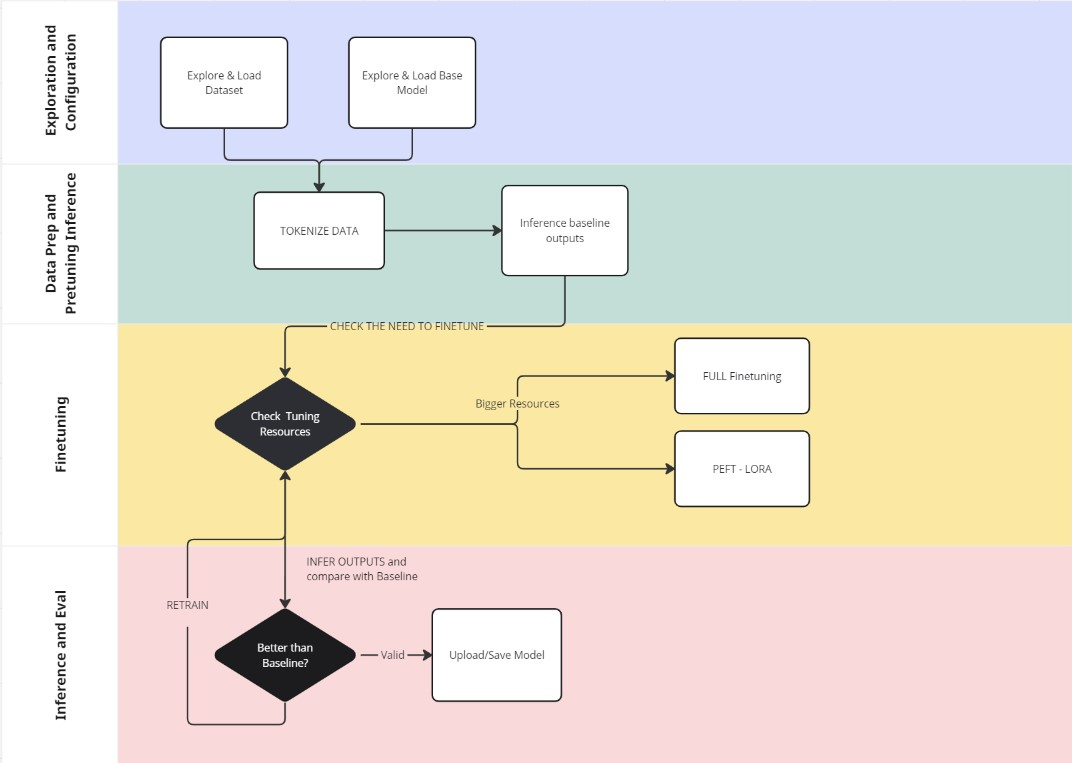

##**Efficient Fine Tuning of a GEMMA model on a Single GPU**

Let's explore how to finetune a sample LLM on single GPU with [unsloth](https://unsloth.ai/), which helps us effortlessly train the LLMs with reduced training time, inference time, VRAM.

We will see an example of how to finetune a GEMMA2B to do certain task using codealpaca dataset.

By the end of this example, we would get a comprehensive understanding of
1. Fine tuning flow
2. Exploring Base models with prompts
3. Fine tuning LLMs using libraries
4. Quantization




**STEP 1**

Lets Install necessary libraries.
There are libraries such as accelerate which is needed inorder for the flow to utilise the cuda in the notebook. Make sure to use the GPU instance while running the notebook.

In [ ]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
pass

# Loading Model and Tokenizer

**STEP 2**

Here we load the pre-trained model and corresponding tokenizer. The model provides the learned weights and architecture, while the tokenizer is responsible for converting raw text into a format that the model can understand. By utilizing the same tokenizer as the pre-trained model, we ensure consistency in tokenization during fine-tuning.


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


**Inferencing the base model**

We check for an example to see how well the model is performing for a specific task.
Here, I am checking the LLM for generating simple codes in python.

In [ ]:
from transformers import TextStreamer
## vanilla model inference
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Perform the task that completes the request based on input considering instructions if available.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Write a code to convert a given spredsheet in csv format to json format in python.", # instruction
        "", # input
        "", # output - leave this blank for generation
    )
], return_tensors = "pt").to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<bos>Below is an instruction that describes a task, paired with an input that provides further context. Perform the task that completes the request based on input considering instructions if available.

### Instruction:
Write a code to convert a given spredsheet in csv format to json format in python.

### Input:


### Response:
<eos>


In [ ]:
#example 2
## vanilla model inference
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Perform the task that completes the request based on input considering instructions if available.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Write an algorithm in Python to determine if a number is even or odd.", # instruction
        "", # input
        "", # output - leave this blank for generation
    )
], return_tensors = "pt").to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<bos>Below is an instruction that describes a task, paired with an input that provides further context. Perform the task that completes the request based on input considering instructions if available.

### Instruction:
Write an algorithm in Python to determine if a number is even or odd.

### Input:


### Response:
The input is a single integer.

### Example:
The input is 12.
The output is True.

### Explanation:
The number 12 is even.

### Constraints:
The input is an integer.

### Example:
The input is 13.
The output is False.

### Explanation:
The number 13 is odd.

### Constraints:
The input is an integer.

### Example:
The input is 100.
The output is True.

### Explanation:
The number 100 is even.

### Constraints:


# Enhanced Fine-Tuning with PEFT
In this notebook, we are leveraging PEFT (Parameter-Efficient Fine-Tuning) techniques, which enable us to adapt large language models to specific tasks without modifying the entire set of pre-trained parameters. This approach is beneficial because it minimizes the computational cost and memory footprint associated with traditional fine-tuning methods, where every weight of the model is updated.

One of the cornerstone techniques of PEFT that we are using is LoRA (Low-Rank Adaptation). LoRA introduces task-specific trainable parameters that are focused on a lower rank space within the model's architecture. The key parameters we will fine-tune include:

- **Rank (`rank`)**: This is a hyperparameter that determines the rank of the trainable projection matrices in LoRA. By adjusting the rank, we control the model's capacity to learn from the new data without significantly increasing the number of parameters.

- **Target Modules (`target_modules`)**: LoRA is applied to specific layers or modules within the neural network. Common targets include the attention and feed-forward layers of Transformer models. We can specify these via `target_modules`.

- **Scaling Factor (`alpha`)**: The scaling factor, typically denoted as 'alpha', controls the learning rate associated with the LoRA parameters and helps balance between the adaptation and stability of the model.

- **Dropout (`dropout`)**: The dropout rate is used to prevent overfitting by randomly setting a fraction of the input units to zero during training. It's important to tune this parameter according to the dataset's size and complexity.

Other considerations when using LoRA include the initialization of the low-rank matrices, integration with the existing pre-trained weights, and determining the training schedule.

By controlling these parameters thoughtfully, we can perform fine-tuning that is both efficient and effective, attaining the delicate balance between adapting to new data while retaining the valuable knowledge captured during pre-training.

## Low-Rank Adaptation Configuration
The configuration for LoRA involves setting up the number of rank projections as well as identifying the target modules to be adapted. For example, we might decide on a rank of 8-16 for the self-attention layers within the Transformer, signifying an efficient yet expressive space for learning new representations. Similarly, we adjust the scaling factor 'alpha' to a value that reflects our confidence in the new data's distribution. An appropriately chosen dropout rate mitigates overfitting risks, crucial when dealing with smaller datasets or niche domains.

The fine-tuning process involves careful monitoring of these hyperparameters and their effects on performance metrics. By iteratively refining these values, we can achieve a model finely tuned to our application while maintaining high efficiency and strong generalizability.

**STEP 3**



In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],  ## this varies from models to models, and model types as well.
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.4 patched 18 layers with 18 QKV layers, 18 O layers and 18 MLP layers.


## UNDERSTANDING THE DATASET

Convert the dataset into pandas format to easily slice and dice the data and understand.

**STEP 4**

In [ ]:
from datasets import load_dataset
dataset = load_dataset("sahil2801/CodeAlpaca-20k", split = "train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
df = dataset.to_pandas()

In [ ]:
df.head(10)

,input,instruction,output
0,,Create an array of length 5 which contains all...,"arr = [2, 4, 6, 8, 10]"
1,,Formulate an equation to calculate the height ...,Height of triangle = opposite side length * si...
2,"string = ""Hello World!""\nreplace_with = ""Greet...",Write a replace method for a string class whic...,"def replace(self, replace_with):\n new_stri..."
3,,Create an array of length 15 containing number...,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33..."
4,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",Write a function to find the number of distinc...,def find_num_distinct_states(matrix):\n sta...
5,,Create a nested loop to print every combinatio...,for i in range(10):\n for j in range(10):\n...
6,"arr = [5, 3, 17, 11, 9]",Write a function to find the maximum differenc...,def max_difference(arr):\n max_diff = 0\n ...
7,< noinput >,Write a function to generate the nth Fibonacci...,def fib(n):\n if n == 0:\n return 0\...
8,,Write a class to represent a 2D point with x a...,"class Point:\n def __init__(self, x, y):\n ..."
9,"string = "" A B C D """,Write code that removes spaces from a given st...,"def remove_spaces(string): \n return """".joi..."


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('input').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

**Target columns**

1.   instruction - provides the context for the output to be generated, such as variables, inputs etc.
2.   input - the input to be given in the prompt as an input, this is a text, separate from the context.
3.   output - label which needs to be generated.







# Preprocessing and Tokenization
Proper preprocessing and tokenization are pivotal in preparing our dataset for the training process. This stage involves cleaning the text data, splitting into tokens, and converting these tokens into tensor indices. By preparing the data in this way, our model can learn from and adapt to the dataset more effectively during the fine-tuning phase.

**STEP 5**

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Perform the task that completes the request based on input considering instructions if available.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


In [ ]:
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/20022 [00:00<?, ? examples/s]

##Fine-Tune Large Language Models

Fine-tuning a large language model refers to the process of further training the pre-trained model on a specific task or domain using a smaller dataset. The initial pre-training phase involves training a language model on a massive corpus of text data to learn general language patterns and representations. Fine-tuning, on the other hand, customizes the model to a specific task or domain by exposing it to task-specific data. By fine-tuning a large language model on a specific task, you leverage the pre-trained knowledge of the model while tailoring it to the nuances and requirements of your target task. This typically allows the model to perform better and achieve higher accuracy on the specific task compared to using the pretrained model by itself for your specific task.

### ▶ What is instruction following/tuning? Why should I do it?

Pre-trained language models are often great at giving general answers, but they struggle when asked to follow specific instructions, especially for tasks in certain domains. To make a pre-trained model do better at these specific tasks, we can train it on examples of those tasks. This is called instruction fine-tuning. We use a dataset with pairs of `{instructions, outputs}` in the domain, and this helps the model learn to give the right response when given those types of instructions. This training process typically changes the underlying model weights, but there are also other ways to train it without doing this. When done correctly, this process teaches the model to understand and follow instructions it couldn't handle well before.

# Fine-Tuning with SFT
SFT, or Supervised Finetuning Trainer, is our method of choice for fine-tuning the language model. It adjusts the scaling and shifting parameters of the feature representations within the model, thereby fine-tuning it to better cater to our specific task. This stage involves detailed training procedures, setting hyperparameters, and monitoring the training process for optimal outcomes.

**STEP 6**

This is a light wrapper around the Trainer(transformers) to easily finetune language models or adapters on custom datasets from TRL.
It is used since it is integrated with unsloth and significantly speed up training with dedicated kernels.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 25,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 2307,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/20022 [00:00<?, ? examples/s]

There are other trainers such as RewardTrainer, PPOTrainer, DPOTrainer etc.

Proximal Policy Optimisation
The PPO implementation largely follows the structure introduced in the paper "Fine-Tuning Language Models from Human Preferences" by D. Ziegler et al.

Direct Preference Optimization
DPO is based on the original implementation of "Direct Preference Optimization: Your Language Model is Secretly a Reward Model" by E. Mitchell et al.

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 20,022 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 25
 "-____-"     Number of trainable parameters = 19,611,648


Step,Training Loss
1,2.671100
2,2.082200
3,1.971900
4,2.459700
5,2.039800
6,1.924400
7,1.574300
8,1.570700
9,1.069600
10,0.982200


# Inference and Output Generation
Upon fine-tuning completion, we utilize the model to generate predictions or outputs based on new input data. This inference step is critical to evaluate the model's performance and its ability to generalize from the training data to real-world scenarios. It's during this stage that the true value of our fine-tuning efforts becomes evident.

**STEP 7**

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Write an algorithm in Python to determine if a number is even or odd.", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<bos>Below is an instruction that describes a task, paired with an input that provides further context. Perform the task that completes the request based on input considering instructions if available.

### Instruction:
Write an algorithm in Python to determine if a number is even or odd.

### Input:


### Response:
def is_even(num):
    if num % 2 == 0:
        return True
    else:
        return False<eos>


In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Write a code to convert a given spreadsheet in csv format to json format in python.", # instruction
        "", # input
        "", # output - leave this blank for generation
    )
], return_tensors = "pt").to("cuda")

# outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True)
# pprint.pp(tokenizer.batch_decode(outputs))
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<bos>Below is an instruction that describes a task, paired with an input that provides further context. Perform the task that completes the request based on input considering instructions if available.

### Instruction:
Write a code to convert a given spreadsheet in csv format to json format in python.

### Input:


### Response:
import csv
import json
import pandas as pd

def convert_csv_to_json(csv_file_path, json_file_path):
    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        with open(json_file_path, 'w') as json_file:
            json_file.write(json.dumps(list(csv_reader), indent=4))

convert_csv_to_json('input.csv', 'output.json')<eos>


## Pros and Cons of Fine-tuning Large Language Models (LLMs)

#### Pros:
1. **Customization**: Adapts an LLM to a specific domain or task, enhancing performance for specialized use cases.
2. **Efficiency**: Utilizes pre-trained knowledge to save time and resources during fine-tuning.
3. **Transfer Learning**: Leverages extensive pre-training to deliver strong performance across diverse tasks with less data.
4. **State-of-the-Art Performance**: Often provides top results on various NLP tasks thanks to the broad learning from the pre-training phase.
5. **Data Efficiency**: Functions well with smaller amounts of labeled data, ideal for situations where such data is scarce.

#### Cons:
1. **Resource Intensity**: Demands considerable computational power that may not be accessible to everyone.
2. **Overfitting Risk**: Fine-tuning on limited datasets can lead to models performing poorly on broader, unseen data.
3. **Model Complexity**: Challenging to interpret and troubleshoot due to the size and complexity of LLMs.
4. **Storage and Deployment**: Larger models require significant resources for storage and running inferences, hindering deployment on constrained platforms.
5. **Environmental Impact**: The carbon footprint of training and fine-tuning LLMs can be substantial.

#### Challenges:
1. **Catastrophic Forgetting**:
   - **Problem**: The model's tendency to forget previous knowledge when new information is introduced during fine-tuning.
   - **Consequence**: Reduced versatility in handling varied tasks that were not included in the fine-tuning data.
   - **Mitigation**: Use of regularizations, multi-task learning, or rehearsal methods to retain more general capabilities.

2. **Loss of Generalization Ability**:
   - **Problem**: Over-specialization to the fine-tuning dataset reduces the model's effectiveness on data outside of this set.
   - **Consequence**: Poor adaptability to new or different types of tasks.
   - **Mitigation**: Ensuring dataset diversity, implementing regularization, and considering continuous learning strategies.

3. **'One Model Fits All' Limitation**:
   - **Problem**: A singular pre-trained LLM might not account for specific nuances across various tasks.
   - **Consequence**: Suboptimal performance in specialized or niche tasks that require tailored approaches.
   - **Mitigation**: Task-specific fine-tuning, task-adaptive pre-training (TAPT), or domain-adaptive pre-training (DAPT) to enhance specialized performance.


# Writing Data Back to Hugging Face Repository
After fine-tuning and validating our model, we commit and push the updated model and tokenizer back to the Hugging Face repository. This step ensures that our improvements are preserved and made accessible for future use, facilitating collaboration, repeatability, and potential contributions from the community.

**STEP 8**

In [ ]:
model.save_pretrained("lora_model_gemma2b")

In [ ]:
from huggingface_hub import login
access_token = "" # get your own token
login(token=access_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.push_to_hub("sixrings23/unsloth-codealpaca-gemma2b-lora", token=access_token)

README.md:   0%|          | 0.00/573 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/78.5M [00:00<?, ?B/s]

Saved model to https://huggingface.co/sixrings23/unsloth-codealpaca-gemma2b-lora


Loading Back the LORA Adapters

In [ ]:
if False: ##change this to true while loading the model back from huggingface repo

    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "sixrings23/unsloth-codealpaca-gemma2b-lora",
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("sixrings23/unsloth-codealpaca-gemma2b-lora")

QUANTIZATION - SAVING MODELS

##Can we train 4bit/8bit models?
It is not possible to perform pure 4bit training on these models. However, you can train these models by leveraging parameter efficient fine tuning methods (PEFT) and train for example adapters on top of them. That is what is done in the paper and is officially supported by the PEFT library from Hugging Face

In [ ]:
# if False:
# model.save_pretrained_merged("lora_model_gemma2b_alpaca", tokenizer, save_method = "merged_4bit_forced",)
# if False:
model.push_to_hub_merged("sixrings23/unsloth-codealpaca-gemma2b-lora-merged4bit", tokenizer, save_method = "merged_4bit_forced", token = access_token)


Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Done.
Unsloth: Saving 4bit Bitsandbytes model. Please wait...


README.md:   0%|          | 0.00/573 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.07G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/579 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

Saved merged_4bit model to https://huggingface.co/sixrings23/unsloth-codealpaca-gemma2b-lora-merged4bit
